# Selecting the features for the model
This part of the project is focused on the selection of the features that has an impact on the target feature `churn`.
To do so we used the sklearn library to standadize the dataframe, and `f_classif` and `RandomForestClassifier` to determine
which feature is important, after which we created a function to finetune the selection based on a threshold.

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', None)
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
warnings.filterwarnings('ignore')

In [2]:
# Loading the clean_data
file = open(r'./data_files/cleaned_data.pk', 'rb')
clean_data = pickle.load(file)
file.close()

<b>In the cell below we created `feature_engineering` function to visually represent the most important feature using `f_classif` and `RandomForestClassifier` to see at a glance which of the features stands out.<b>

In [3]:
def feature_engineering():
    
    
    #The first five lines generate more features that can increase the relationship of the new columns with churns
    clean_data['total_cons'] = clean_data['cons_12m'] + clean_data['cons_gas_12m']
    clean_data['price'] = ((clean_data['price_p1_var'] + clean_data['price_p1_fix']) + (clean_data['price_p2_var'] + clean_data['price_p2_fix']) + (clean_data['price_p3_var'] + clean_data['price_p3_fix']))/3
    clean_data['aver_forcast_ene'] = (clean_data['forecast_price_energy_p1'] + clean_data['forecast_price_energy_p2'])/2
    clean_data['cons/price1'] = clean_data['total_cons']/clean_data['price']
    clean_data['forcast_price'] = (clean_data['forecast_price_energy_p1'] + clean_data['forecast_price_pow_p1'] + clean_data['forecast_price_pow_p1'])/2
    
    # The X variable is a list of columns except churn and the date columns with can render the model useless
    X = clean_data.drop(['churn', 'date_activ', 'date_end', 'date_renewal'], 1)
    y = clean_data.churn #The y variable just contain only the churn column
    X.replace(np.inf, 0, inplace=True) #Due to the new created columns some data point as a value of 1/0 which will arise into an error if being feed into the model so to aviod such error I replace all 1/0 or equivalent with 0
    
    
    # I standardize the X value using the sklearn package
    scaler = StandardScaler()  
    X_ = scaler.fit_transform(X)
    
    
    # I created a model, randomforestclassifier, to determine how my model is performing has as new column/feature are being added to my dataset
    model = RandomForestClassifier()
    score = cross_val_score(model, X_, y.values, scoring = 'roc_auc', n_jobs=-1)
    score = score.mean()
    #print('mean score using roc_auc {0:.2f}'.format(score))
    
    
    # randomforestclassifier has a parameter that can show the feature importances base on the model
    model.fit(X_, y.values)
    feature_importance = model.feature_importances_
    df_fea_imp = pd.Series(feature_importance, index = X.columns, name = 'feature_import')
    #print('\nfeature importance using random forest classifier\n', df_fea_imp.sort_values(ascending = False))
    
    
    # This another of way to check the feature importance of dataset for ordinal, categorical prediction
    k_best = SelectKBest(f_classif, k = 17)
    X_new = k_best.fit_transform(X_, y)
    impt = pd.Series(k_best.scores_, index = X.columns)
    #print('\nfeature importance using f_classifier\n', impt.sort_values(ascending = False))
    
    # Both of the method used in selecting the feature importance are put into graphical view
    fig = plt.figure(figsize = (25.0, 10.0))
    plt.subplot(1,2,1)
    df_fea_imp.sort_values(ascending = False).plot(kind = 'barh', title = 'feature importance using random forest classifier')
    plt.subplot(1,2,2)
    impt.sort_values(ascending = False).plot(kind = 'barh', title = 'Feature importance using f_classifier')
    fig.savefig(r'.\images\feature_importances.png')
    return df_fea_imp, impt

<b> The `feature_engineering` function returns the scores of both the `f_classif` and `RandomForestClassifier` which is needed for removing the least important features from the dataframe.</b>

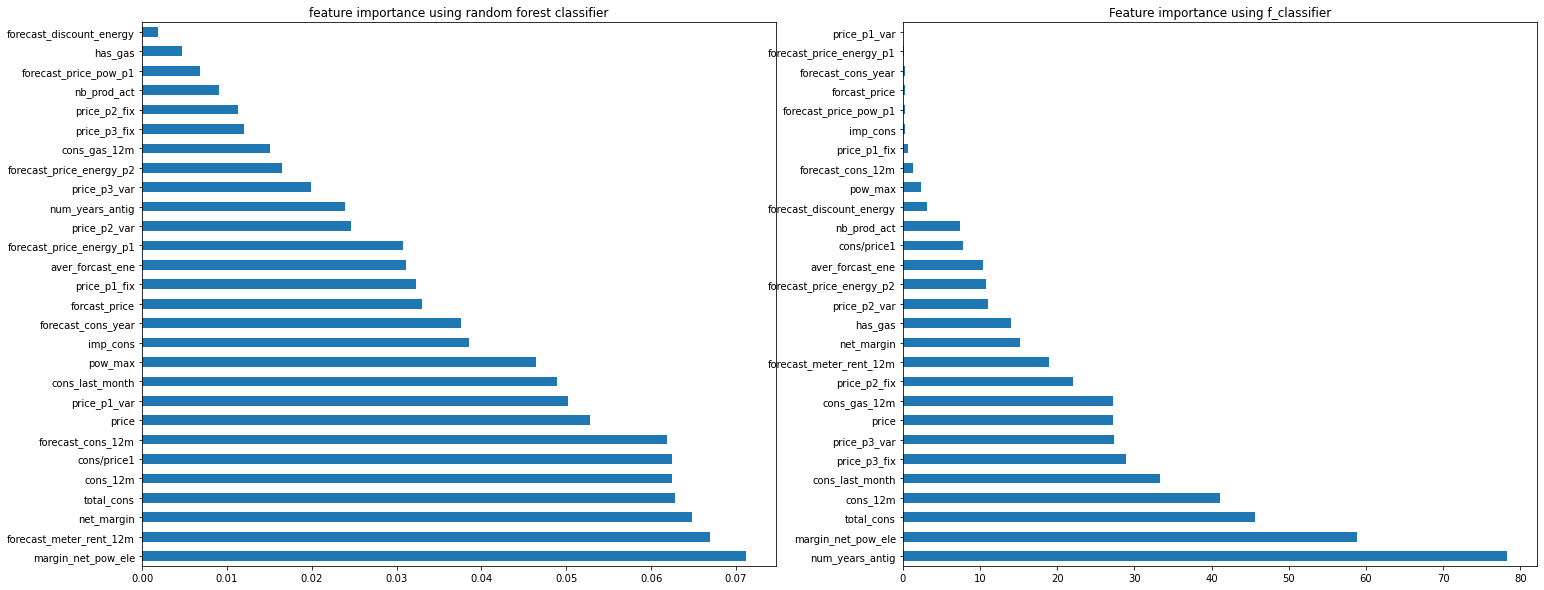

In [4]:
random_features_imp, f_classifier_imp = feature_engineering()

In [5]:
# A funtion that returns a series of important features based on a threshold
# The function accepts three parameters:
# data-the series of scores
# thresh - the threshold to select important features
# name - name of the method used in the scoring (f_classif, RandomForestClassifier)
def important_feature(data, thresh, model_used):
    dictionary = {}
    for feature in list(data.index):
        if data[feature] > thresh:
            dictionary[feature] = data[feature]

     # pd.DataFrame.from_dict(rf_imp_feat)
    return pd.Series(dictionary, name = model_used)

In [6]:
# features1 and features2 after removing the less important features
features1 = important_feature(random_features_imp, 0.037, 'random_forest').sort_values(ascending=False)
features2 = important_feature(f_classifier_imp, 20, 'f_classifier').sort_values(ascending=False)

### The dataframe of important features
As we can see the dataframe now has 18 columns out of the original 32 columns

In [7]:
features = pd.concat([features1, features2], axis=1).index.tolist()
features_df = clean_data[features].reset_index(drop=True)
print('Number of columns before feature selecton: %d\n' % clean_data.shape[1],
      'Number of columns after feature selection %d' % features_df.shape[1])

Number of columns before feature selecton: 32
 Number of columns after feature selection 18


In [8]:
target = pd.DataFrame()
target['churn'] = clean_data['churn'].values
target.head()

,churn
0,0
1,1
2,0
3,0
4,0


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_df, target, random_state=0)

There are some infinite values in the dataset which I'll have to take care of because it will affect the model

In [10]:
np.isinf(X_train).sum()

margin_net_pow_ele          0
forecast_meter_rent_12m     0
net_margin                  0
total_cons                  0
cons_12m                    0
cons/price1                11
forecast_cons_12m           0
price                       0
price_p1_var                0
cons_last_month             0
pow_max                     0
imp_cons                    0
forecast_cons_year          0
num_years_antig             0
price_p3_fix                0
price_p3_var                0
cons_gas_12m                0
price_p2_fix                0
dtype: int64

In [11]:
np.isinf(X_test).sum()

margin_net_pow_ele          0
forecast_meter_rent_12m     0
net_margin                  0
total_cons                  0
cons_12m                    0
cons/price1                10
forecast_cons_12m           0
price                       0
price_p1_var                0
cons_last_month             0
pow_max                     0
imp_cons                    0
forecast_cons_year          0
num_years_antig             0
price_p3_fix                0
price_p3_var                0
cons_gas_12m                0
price_p2_fix                0
dtype: int64

In [12]:
X_train.replace([np.inf, -np.inf], 0, inplace=True)

In [13]:
X_test.replace([np.inf, -np.inf], 0, inplace=True)

In [14]:
cols = list(X_test.columns)

In [15]:
np.isinf(features_df).sum()

margin_net_pow_ele          0
forecast_meter_rent_12m     0
net_margin                  0
total_cons                  0
cons_12m                    0
cons/price1                21
forecast_cons_12m           0
price                       0
price_p1_var                0
cons_last_month             0
pow_max                     0
imp_cons                    0
forecast_cons_year          0
num_years_antig             0
price_p3_fix                0
price_p3_var                0
cons_gas_12m                0
price_p2_fix                0
dtype: int64

In [16]:
features_df.replace([np.inf, -np.inf], 0, inplace=True)

In [17]:
features_with_target = features_df
features_with_target['target'] = target['churn'] 

There is imbalance in the dataset which will lead to a bias prediction which is not what we want, so the solution used here is the oversampling of the dataset.

In [18]:
df_class_0 = features_with_target[features_with_target.target == 0]
df_class_1 = features_with_target[features_with_target.target == 1] 

In [19]:
print('df_class_0: ', len(df_class_0))
print('df_class_1: ', len(df_class_1))

df_class_0:  14367
df_class_1:  1549


In [20]:
count_class_0, count_class_1 = features_with_target.target.value_counts()

In [21]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_1_over, df_class_0], axis=0)

In [22]:
print('Random over-sampling:')
print(df_test_over.target.value_counts())

Random over-sampling:
0    14367
1    14367
Name: target, dtype: int64


As we can see the dataset now has a balance between the two classes which should significantly avoid bias in the prediction

## Separating the oversampled dataset to features and target in order to split it into training set and test set

In [25]:
vectors_over = df_test_over[cols]
target_over = df_test_over.target

In [26]:
X_tr, X_ts, y_tr, y_ts = train_test_split(vectors_over, target_over, random_state=0)

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

### Training the model

In [28]:
clf.fit(X_tr, y_tr)

RandomForestClassifier()

## Saving the trained model

In [33]:
with open(r'./data_files/model_RFC.pk', 'wb') as file:
    pickle.dump(clf, file)

## Predicticting the churn for the training set and the test set

In [29]:
y_train_pred = clf.predict(X_train)

In [30]:
y_test_pred = clf.predict(X_test)

## The f1_score shows how accurate our model is.

In [31]:
from sklearn.metrics import f1_score

In [32]:
print('The f1_score for the training dataset is: {:.2f}%'.format(f1_score(y_train, y_train_pred) * 100.0))
print('The f1_sxore for the test dataset is: {:.2f}%'.format(f1_score(y_test, y_test_pred) * 100.0))

The f1_score for the training dataset is: 98.07%
The f1_sxore for the test dataset is: 98.53%
